#Mount GDrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%cd /content/drive/'My Drive'/'Colab Notebooks'/
# cd /content/drive/My Drive/Sop_GPS_Classification/PreProcessedData_Final/
# %cd /content/drive/'My Drive'/'PreProcessedData_Final'

/content/drive/My Drive/Colab Notebooks


In [ ]:
cd 'PreProcessedData_Final/'

/content/drive/My Drive/Colab Notebooks/PreProcessedData_Final


#Import the required libraries

In [ ]:
!pip install pyproj

     |████████████████████████████████| 10.1MB 24kB/s 


In [ ]:
import numpy as np
import pandas as pd
# import sklearn as sk
# from sklearn.decomposition import PCA
# from geopy.distance import geodesic
# import mpu
import pyproj
# import warnings
# warnings.filterwarnings('ignore')
# except:
#     pass
# import keras
# # from keras.activation import adam
# from keras.models import Sequential
# from keras.layers import Dense, LSTM, Input
# from keras.utils import to_categorical
import glob

from datetime import datetime
from datetime import timedelta
from IPython.display import clear_output


#Preprocessing

Extracting all the required file names.

In [ ]:
path = '20190818'
all_files = glob.glob(path+ "/*.csv")
print(all_files)
clear_output()

Reading all the files as dataframes and appending them to a list.

In [ ]:
li=[]
i=0
for filename in all_files :
    df = pd.read_csv(filename, index_col=None, header= None, sep=';')
    if (i%1000 == 0):
      print(i)
    i = i + 1
    li.append(df)
clear_output()

Removing redundant columns.

In [ ]:
for i in range(len(li)):
    if(i!=0):
      df=li[i]
      df.drop(['d1', 'd2', 'd3'], axis=1, inplace=True)
      # df.rename(columns={4:'d1', 6:'d1', 7:'d2', 8:'d3'}, inplace=True)
      if i%1000 == 0:
        print(i)
      i=i+1
clear_output()

Creating a dictionary for storing all the information of one vehicle in one dataframe.

In [ ]:
uniqueID=dict()
for i in range(len(li)):
  for j in range(li[i].shape[0]):
    if(uniqueID.get(li[i].at[j,'id']) == None):
      uniqueID[li[i].at[j,'id']] = 1
    else:
      uniqueID[li[i].at[j,'id']] += 1
  if i%1000 == 0:
    print(i)

clear_output()

Creating the necessary columns.

In [ ]:
dictOfList={}
for ID in uniqueID:
    dictOfList[ID] = [] #create a dictionary of lists
for j in range(len(li)):
  for k in range(li[j].shape[0]):
    tmpDict = {}
    tmpDict.update({'id':li[j].at[k,'id']})
    tmpDict.update({'time':li[j].at[k,'time']})
    tmpDict.update({'lat':li[j].at[k,'lat']})
    tmpDict.update({'long':li[j].at[k,'long']})
    tmpDict.update({'speed':li[j].at[k,'speed']})
    # tmpDict.update({'class':li[j].at[k,'class']})
    dictOfList[li[j].at[k,'id']].append(tmpDict)   
  if(j%1000 == 0):
    print(j)  
clear_output() 

Storing all the information about a vehicle in one single dataframe in the dictionary of dataframes.

In [ ]:
preData=[]
for key in dictOfList:
  frame=pd.DataFrame(dictOfList[key])
  preData.append(frame)

Saving this  processed data in csv format on disk.

In [ ]:
for i in range(len(preData)):
  name = './TestPreProcessedData_1/DataFile_'+str(i+1)+'.csv'
  preData[i].to_csv(name)

Reading the vehicle-wise data from disk.

In [ ]:
path = 'TestPreProcessedData_1'
all_files = glob.glob(path+ "/*.csv")
vehicles=[]
i = 0
for fileName in all_files:
  frame = pd.read_csv(fileName, sep = ',')
  vehicles.append(frame)
  if i%1000 == 0:
    print(i)
  i += 1

clear_output()

Adding the necessary columns for learning the model.

In [ ]:
# Adding new columns for speed,datetime,etc
for i in range(len(vehicles)):
    vehicles[i].insert(loc=6, column='dist', value=1.0)
    vehicles[i].insert(loc=7, column='LatLongSpeed', value=1.0)
    vehicles[i].insert(loc=8, column='acc', value=1.0)
    vehicles[i].insert(loc=9, column='datetime',value=datetime.strptime('1857/08/15 00:00:00', '%Y/%m/%d %H:%M:%S'))
    if(i%1000==0):
      print(i)
clear_output()

Parsing the timestamps into the datetime format.

In [ ]:
#populating datetime and sorting according to time
for j in range(len(vehicles)):
    for k in range(0, vehicles[j].shape[0]):
        vehicles[j].at[k,'datetime'] = datetime.strptime(vehicles[j].at[k,'time'], '%Y/%m/%d %H:%M:%S')
    vehicles[j].sort_values(by='datetime',inplace=True,na_position='first')
    if(j%1000 == 0):
      print(j)
clear_output()

Dropping rows with duplicate values of timestamps.

In [ ]:
for i in range(len(vehicles)):
  vehicles[i].drop_duplicates(subset=['datetime'], keep='first', inplace=True)

In [ ]:
#Just to check whether duplicates remain or not
for i in range(len(vehicles)):
  if(any(vehicles[i]['datetime'].duplicated()) == True):
    print("Duplicate Exists in "+str(i))

Creating a new list of dataframes (one for each vehicle) for further preprocessing.

In [ ]:
vehicles_new=[]
for i in range(len(vehicles)):
    reset_index_df = vehicles[i].reset_index(drop=True)
    vehicles_new.append(reset_index_df[['id', 'datetime','lat','long','dist','speed','LatLongSpeed','acc']].copy())s

Checking for duplicate timestamps and empty vehicle data.

In [ ]:
#In case, if duplicates remain, delete them forcefully
for i in range(len(vehicles_new)):
    duplicateRowsDF = vehicles_new[i][vehicles_new[i].duplicated(subset = ['datetime'],keep = 'first')]
    print("Duplicate Rows of :"+ str(i))
    index_duplicates=list(duplicateRowsDF.index.values)
    vehicles_new[i].drop(vehicles_new[i].index[index_duplicates],inplace = True)
clear_output()

In [ ]:
#Check if some dataframe is empty or not
for i in range(len(vehicles_new)):
  if(vehicles_new[i].empty):
    print("I am Empty")
clear_output()

Saving this data back to disk for security.

In [ ]:
for i in range(len(vehicles_new)):
  name = './TestPreProcessedData_2/DataFile_'+str(i+1)+'.csv'
  vehicles_new[i].to_csv(name)

Reading back the vehicular data.

In [ ]:
vehicles_new=[]
path = 'TestPreProcessedData_2'
all_files = glob.glob(path+ "/*.csv")
i = 0
for fileName in all_files:
  frame = pd.read_csv(fileName, sep = ',')
  vehicles_new.append(frame)
  for k in range(len(frame)):
    vehicles_new[i].at[k,'datetime'] = datetime.strptime(vehicles_new[i].at[k,'datetime'], '%Y-%m-%d %H:%M:%S')
  if i%1000 == 0:
    print(i)
  i += 1

clear_output()

Extracting speed and acceleration at verious timestamps using GPS coordinates.

In [ ]:
for j in range(len(vehicles_new)):
    # if(not vehicles_new[j].empty):
    vehicles_new[j].at[0,'dist']=0
    vehicles_new[j].at[0,'LatLongSpeed']=0
    vehicles_new[j].at[0,'acc']=0
    for k in range(1, vehicles_new[j].shape[0]):
        geod = pyproj.Geod(ellps='WGS84')
        lat0=vehicles_new[j].at[k-1,'lat']
        lon0=vehicles_new[j].at[k-1,'long']
        lat1=vehicles_new[j].at[k,'lat']
        lon1=vehicles_new[j].at[k,'long']

        a1, a2, dist = geod.inv(lon0, lat0, lon1, lat1)
        vehicles_new[j].at[k,'dist']=dist
        
        timediff = (vehicles_new[j].at[k,'datetime'] - vehicles_new[j].at[k-1,'datetime']).total_seconds()/3600
        
        
        vehicles_new[j].at[k,'LatLongSpeed']=(vehicles_new[j].at[k,'dist']-vehicles_new[j].at[k-1,'dist'])/timediff
        
        vehicles_new[j].at[k,'acc']=(vehicles_new[j].at[k,'speed']-vehicles_new[j].at[k-1,'speed'])/timediff
    
    if(j%1000 == 0):
      print(j)
clear_output()

Checking for rows with data that cannot be processed further.

In [ ]:
# To check if nan, inf or -inf exist in some entry of some row of some dataframe
for i in range(len(vehicles_new)):
    if(vehicles_new[i].isin([np.nan, np.inf, -np.inf]).any(1).values.any()):
        print(str(i)+" Exist")
    else:
        print(str(i)+" Not Exist")
clear_output()

For each vehicle, calculating aggregated parameters of speed and acceleration.

In [ ]:
df2=pd.DataFrame(columns=['id','speed1_avg','speed2_avg','speed1_var','speed2_var','acc_avg','acc_var'])
for i in range(len(vehicles_new)):
    if(not vehicles_new[j].empty):
        df2.at[i,'speed1_avg'] = vehicles_new[i]['speed'].mean()
        df2.at[i,'speed2_avg'] = vehicles_new[i]['LatLongSpeed'].mean()
        df2.at[i,'speed1_var'] = vehicles_new[i]['speed'].var()
        df2.at[i,'speed2_var'] = vehicles_new[i]['LatLongSpeed'].var()
        df2.at[i,'acc_avg'] = vehicles_new[i]['acc'].mean()
        df2.at[i,'acc_var'] = vehicles_new[i]['acc'].var()
        df2.at[i,'id']= vehicles_new[i].at[0,'id']
        # df2.at[i,'class']= vehicles_new[i]['class'][0]
    if(i%1000 == 0):
      print(i)
clear_output()

Finally, saving the preprocessed data.

In [ ]:
df2.to_csv('./TestPreProcessedData_Final/FinalData.csv')

#Analysis and Training


In [ ]:
!ls
%cd drive/

FinalData.csv  FinalData.gsheet
[Errno 2] No such file or directory: 'drive/'
/content/drive/My Drive/Colab Notebooks/PreProcessedData_Final


Reading the vehicular data from disk.

In [ ]:
df2 = pd.read_csv('FinalData.csv')
df2['class'].unique()
# df2['class'].nunique()

array(['Car', 'Not available', 'Ambulance', 'Motor Cycle', 'Bus', 'Cab',
       'JCB', 'Truck', 'Tractor', 'Mini_Bus', 'School_Bus'], dtype=object)

Importing the required libraries.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import sys
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold

Dropping the columns which are useless, and replacing NA values with mean.

In [ ]:
df4 = df2
df4 = df4[df4['class'] != 'Not available']
y = df4['class']
df4=df4.drop(columns = ['id','class'])
df4.drop(df4.columns[df4.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
# 'speed1_avg','speed2_avg','speed1_var','speed2_var','acc_avg','acc_var'
df4 = df4.fillna(df4.mean())

print(df4.shape)

(3252, 6)


Scaling the data.

In [ ]:
names = df4.columns
scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit_transform(df4)
scaled_df = pd.DataFrame(scaled_df, columns=names)
df4=scaled_df

Plotting the data for analysis.

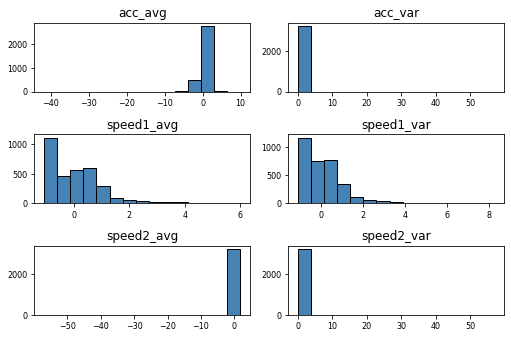

In [ ]:
df4.hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)    
plt.tight_layout(rect=(0, 0, 1.2, 1.2))   

In [ ]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df4.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.9)
t= f.suptitle('Vehicle Attributes Correlation Heatmap', fontsize=14)

In [ ]:
fig = plt.figure(figsize=(8, 6))
t = fig.suptitle('speed1_avg - speed2_avg - speed1_var - speed2_var - acc_avg - acc_var', fontsize=14)
ax = fig.add_subplot(111, projection='3d')

xs = list(df4['speed1_avg'])
ys = list(df4['speed2_avg'])
zs = list(df4['speed1_var'])
data_points = [(x, y, z) for x, y, z in zip(xs, ys, zs)]

# ss = list(df4['speed2_var'])
colors = ['red' if wt <= 1000 else 'yellow' for wt in list(df4['acc_avg'])]
# markers = [',' if q == 'high' else 'x' if q == 'medium' else 'o' for q in list(df4['acc_var'])]

# ax.scatter(xs, ys, zs, s=50, alpha=0.6, edgecolors='w')
for data, color in zip(data_points, colors):
    x, y, z = data
    ax.scatter(x, y, z, c=color, edgecolors='none')
    # print(data)

ax.set_xlabel('speed1_avg')
ax.set_ylabel('speed2_avg')
ax.set_zlabel('speed1_var')

Principal Component Analysis

In [ ]:
for i in range(1,7): 
  pca = PCA(n_components = i)
  pca.fit(df4)
  print(sum(pca.explained_variance_ratio_))

0.6043523575769868
0.9012425560007675
0.9604297660893899
0.9998299437603065
0.9999997731475788
1.0


# Shallow Models

K-Fold Cross-Validation with k=5.

In [ ]:
cv = KFold(n_splits=5, random_state=2, shuffle=True)
avg_accuracy=0.0
string = ""
for train_index, test_index in cv.split(df4):
  X_tr, X_tst, y_tr, y_tst = df4.iloc[train_index], df4.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
  clf=XGBClassifier(booster='gbtree',objective='multi:softmax',num_class =10,eval_metric = 'merror', 
                     learning_rate=0.5,n_estimators=120,
                      max_depth=5, min_child_weigth = 3,gamma=0,subsample=0.7, colsample_bytree = 0.9,scale_pos_weight = 1,seed = 27)
  model = clf.fit(X_tr, y_tr)
  predicted= model.predict(X_tst)
  string = string + str(round((metrics.accuracy_score(y_tst, predicted)*100),2)) + ' & '
  avg_accuracy = avg_accuracy + metrics.accuracy_score(y_tst, predicted)

string = string + (str(round((avg_accuracy/5)*100,2)))
print(string)

91.09 & 89.71 & 92.15 & 90.77 & 91.54 & 91.05


Splitting the data into train and test sets.

In [ ]:
X_tr, X_tst, y_tr, y_tst = train_test_split(df4, y, test_size=0.3)
# X_tr, X_tst, y_tr, y_tst = train_test_split(df4, y_one_hot, test_size=0.2)

Training Shallow Models.

In [ ]:
#KNN Model
clf=KNeighborsClassifier()
clf.fit(X_tr, y_tr)
predicted= clf.predict(X_tst)
print(metrics.accuracy_score(y_tst, predicted))
print(KNeighborsClassifier())

0.8360655737704918
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')


In [ ]:
#Naive Bayes Model
clf=BernoulliNB()
clf.fit(X_tr, y_tr)
predicted= clf.predict(X_tst)
print(metrics.accuracy_score(y_tst, predicted))

0.805327868852459


In [ ]:

#SVC Model
clf=SVC()
clf.fit(X_tr, y_tr)
predicted= clf.predict(X_tst)
print(metrics.accuracy_score(y_tst, predicted))

0.8370901639344263


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [ ]:
#Random Forest Model
clf=RandomForestClassifier(n_estimators=1000,min_samples_leaf=3)
clf.fit(X_tr, y_tr)
predicted= clf.predict(X_tst)
print(metrics.accuracy_score(y_tst, predicted))
# print(RandomForestClassifier())

0.9313524590163934


Parameter Tuning for Random Forest Classifier.

In [ ]:
# #Tuning Parameters
# rfc = RandomForestClassifier()
# parameters = {
#     "n_estimators":[5,10,50,100],
#     "max_depth":[2,4,8,16,32,64,None],
#     "min_samples_leaf":[1,5,10,50]
# }
# cv = GridSearchCV(rfc,parameters,cv=5)
# cv.fit(X_tr,y_tr.values.ravel())
# print(f'Best parameters are: {cv.best_params_}')
# # print("\n")
# mean_score = cv.cv_results_['mean_test_score']
# std_score = cv.cv_results_['std_test_score']
# params = cv.cv_results_['params']
# for mean,std,params in zip(mean_score,std_score,params):
#   print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

In [ ]:
#Decision Tree Model 
clf=DecisionTreeClassifier(min_samples_leaf=3, max_depth=4)
clf.fit(X_tr, y_tr)
predicted= clf.predict(X_tst)
print(metrics.accuracy_score(y_tst, predicted))

0.9211065573770492


In [ ]:
#Ada Boost Model
clf=AdaBoostClassifier(n_estimators=100,learning_rate=1)
model = clf.fit(X_tr, y_tr)
predicted= model.predict(X_tst)
print(metrics.accuracy_score(y_tst, predicted))
print(AdaBoostClassifier())

0.8801229508196722
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)


In [ ]:
#Gradient Boost Model
clf=GradientBoostingClassifier()
model = clf.fit(X_tr, y_tr,)
predicted= model.predict(X_tst)
print(metrics.accuracy_score(y_tst, predicted))
print(GradientBoostingClassifier())

In [ ]:
#SGD Model
clf=SGDClassifier()
model = clf.fit(X_tr, y_tr)
predicted= model.predict(X_tst)
print(metrics.accuracy_score(y_tst, predicted))
print(SGDClassifier())

In [ ]:
#Bagging Model
clf=BaggingClassifier(n_estimators=100)
model = clf.fit(X_tr, y_tr)
predicted= model.predict(X_tst)
print(metrics.accuracy_score(y_tst, predicted))
print(BaggingClassifier())

Parameter Tuning for XGB Model.

In [ ]:

# for learning_rate in [0.1] :
for learning_rate in [0.01,0.03,0.05,0.1,0.3,0.5,1,3] :
  clf=XGBClassifier(booster='gbtree',objective='multi:softmax',num_class =10,eval_metric = 'merror', 
                     learning_rate=learning_rate,n_estimators=120,
                      max_depth=5, min_child_weigth = 3,gamma=0,subsample=0.7, colsample_bytree = 0.9,scale_pos_weight = 1,seed = 27)
    
  model = clf.fit(X_tr, y_tr)
  predicted= model.predict(X_tst)
  print('learning rate: '+ str(learning_rate) +"    Accuracy: " + str(metrics.accuracy_score(y_tst, predicted)))


learning rate: 0.01    Accuracy: 0.9334016393442623
learning rate: 0.03    Accuracy: 0.9364754098360656
learning rate: 0.05    Accuracy: 0.9405737704918032
learning rate: 0.1    Accuracy: 0.9334016393442623
learning rate: 0.3    Accuracy: 0.9190573770491803
learning rate: 0.5    Accuracy: 0.9272540983606558
learning rate: 1    Accuracy: 0.9200819672131147
learning rate: 3    Accuracy: 0.8739754098360656


In [ ]:
#XGB Model
clf=XGBClassifier(booster='gbtree',objective='multi:softmax',num_class =10,eval_metric = 'merror', 
                     learning_rate=0.5,n_estimators=120,
                      max_depth=5, min_child_weigth = 3,gamma=0,subsample=0.7, colsample_bytree = 0.9,scale_pos_weight = 1,seed = 27)
model = clf.fit(X_tr, y_tr)
predicted= model.predict(X_tst)
print(metrics.accuracy_score(y_tst, predicted))

0.9272540983606558


Parameter Tuning for XGB Model using Grid Search Algorithm.

In [ ]:
param_test1 = {
 'max_depth':range(1,10,1),
 'min_child_weight':range(1,10,1)
}
params = {
        'gamma':[i/10.0 for i in range(0,5)],
        'subsample':[i/10.0 for i in range(6,10)],
        'colsample_bytree':[i/10.0 for i in range(6,10)]
        }

gsearch1 = GridSearchCV(estimator = clf,param_grid = params,iid=False, cv=5)
gsearch1.fit(X_tr,y_tr)
gsearch1.best_params_, gsearch1.best_score_

Printing the best parameters.

In [ ]:
gsearch1.best_params_, gsearch1.best_score_

Data Structures for Paramter Tuning of XGB Classifier.

In [ ]:
# # Tuning parameters
# params = {
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5]
#         }

# param_test1 = {
#  'max_depth':range(3,10,2),
#  'min_child_weight':range(1,6,2)
# }


Printing the results of the Models.

In [ ]:
report = classification_report(y_tst, predicted)
print(report)
matrix = confusion_matrix(y_tst, predicted)
print(matrix)

In [ ]:
#To evaluate the model's predictions
report = classification_report(y_tst, predicted)
print(report)
matrix = confusion_matrix(y_tst, predicted)
print(matrix)

In [ ]:
# Final Accuracy : 93% (Random Forest Classifier)
# F1 Score : 93%

# Neural network

Importing the required libraries.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM

from sklearn import preprocessing
import sys

In [ ]:
#Changing pandas dataframe to numpy array
X = df4.values
y = y.values

In [ ]:
# # #Standarize OR Normalize the data here
# # #standardized_X = preprocessing.scale(X)

# names = df4.columns
# # Create the Scaler object
# scaler = preprocessing.StandardScaler()
# # Fit your data on the scaler object
# scaled_df = scaler.fit_transform(df4)
# scaled_df = pd.DataFrame(scaled_df, columns=names)
# X = scaled_df.iloc[:,1:7].values

# # # np.set_printoptions(threshold=sys.maxsize)



# # # integer encode
# # label_encoder = preprocessing.LabelEncoder()
# # integer_encoded = label_encoder.fit_transform(y)
# # print(integer_encoded)
# # # binary encode
# # onehot_encoder = preprocessing.OneHotEncoder(sparse=False)
# # integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
# # onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
# # print(onehot_encoded)
# # # invert first example
# # inverted = label_encoder.inverse_transform([np.argmax(onehot_encoded[0, :])])
# # print(inverted)



# # #Label Encoder
# # # le = preprocessing.LabelEncoder()
# # # le.fit(y)
# # # y=le.transform(y)

One - hot encoding

In [ ]:
# #Standarize OR Normalize the data here
# #standardized_X = preprocessing.scale(X)

# Onehotcenode
onehotencoder = preprocessing.OneHotEncoder(categories = 'auto' )
y_one_hot = onehotencoder.fit_transform(y.reshape(-1,1)).toarray()

Splitting the data into test and train sets.
Initializing the model.

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y_one_hot,test_size = 0.41)

# define the keras model
model = Sequential()
model.add(Dense(8, input_dim=X.shape[1], activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(15, activation='relu'))
# model.add(Dense(12, activation='relu'))
model.add(Dense(10, activation='softmax'))


Compiling the keras model and training it.

In [ ]:
#Compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit Keras Model.
history = model.fit(X_train, y_train, epochs=6000, batch_size=64)

# Make Predictions
y_pred = model.predict(X_test)
#Converting predictions to label
pred = list()
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))
#Converting one hot encoded test label to label
test = list()
for i in range(len(y_test)):
    test.append(np.argmax(y_test[i]))

from sklearn.metrics import accuracy_score
a = accuracy_score(pred,test)
print('Accuracy is:', a*100)

Printing the accuracy.

In [ ]:
print('Accuracy is:', a*100)

Plotting the results.

In [ ]:
import matplotlib.pyplot as plt

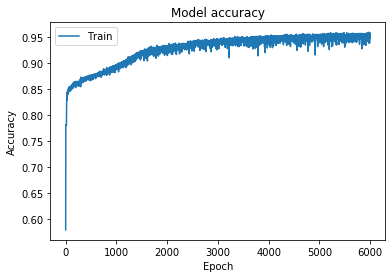

In [ ]:
plt.plot(history.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


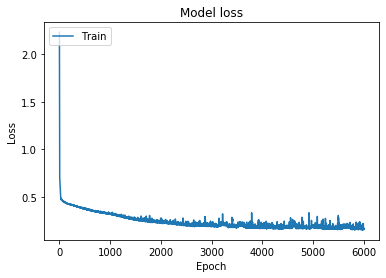

In [ ]:

plt.plot(history.history['loss'])
# plt.plot(historyhistory['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [ ]:
report = classification_report(y_tst, predicted)
print(report)
matrix = confusion_matrix(y_tst, predicted)
print(matrix)

Printing the results of the model.

In [ ]:
print(y_pred)

In [ ]:
print(pred)

# Applying the model on given dataset

Going to the path where the preprocessed vehicular data is present.

In [ ]:
cd /content/drive/'My Drive'/TestPreProcessedData_Final/

Reading the test file

In [ ]:
df=pd.read_csv('FinalData.csv')

Dropping the undesired columns.

In [ ]:

df.drop(['Unnamed: 0'], axis=1, inplace=True)

Creating a copy of the data for actually running the model.

In [ ]:

df2=df.drop(['id'], axis=1)

Scaling the data.

In [ ]:
names = df2.columns
scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit_transform(df2)
scaled_df = pd.DataFrame(scaled_df, columns=names)
df2=scaled_df

Dropping the columns with values in the original dataframe for writing back to disk, and adding a column for class.

In [ ]:

df.drop(['speed1_avg', 'speed2_avg', 'speed1_var', 'speed2_var', 'acc_avg','acc_var'], axis=1, inplace=True)
df.insert(loc=1, column='class', value='None')

Running the model and writing to disk.

In [ ]:
y=model.predict(df2)
df['class']=y
df.to_csv('./TestPreProcessedData_Final/Result.csv')